In [18]:
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import find_greedy_credible_levels
import ligo.skymap.plot as skplot
from healpy import npix2nside
from astropy_healpix import HEALPix
import astropy.units as u
from gwpy.table import EventTable
from gwpy.time import to_gps
from io import StringIO, BytesIO
from astropy.table import vstack
from functools import lru_cache
import numpy as np
from astropy.io import fits 
import base64
from matplotlib.colors import rgb2hex
from astropy.utils.misc import JsonCustomEncoder
import json

In [19]:
t1 = "2018-07-26T12:00:00" 
t2 = "2021-07-28T12:00:00" 
do_cone_search = "true"
ra = 97.5
dec = -40.
radius = 10.0 #degree
level_threshold = 10 #percent
contour_levels = "50,90" #percent, comma-separated

In [20]:
t1 = to_gps(t1)
t2 = to_gps(t2)
do_cone_search = True if do_cone_search in ('true', 'True', 'yes', True) else False
contour_levels = [int(x) for x in contour_levels.split(',')]

In [21]:
tabs = []
columns_to_add = ['commonName', 
                 'GPS',
                 'luminosity_distance',
                 'luminosity_distance_lower',
                 'luminosity_distance_upper',
                 'mass_1_source', 
                 'mass_1_source_lower', 
                 'mass_1_source_upper', 
                 'mass_2_source', 
                 'mass_2_source_lower', 
                 'mass_2_source_upper']
for catalog in ("GWTC-1-confident", "GWTC-2", "GWTC-3-confident"):
    tabs.append(EventTable.fetch_open_data(catalog, selection=f'GPS > {t1} && GPS < {t2}')[columns_to_add])
tab = vstack(tabs)    

In [22]:
@lru_cache
def reg_idxs(nside, ra, dec, radius):
    point = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=u.deg)
    hp = HEALPix(nside,order='nested', frame='icrs')
    return hp.cone_search_skycoord(point, radius*u.deg)

skymap_files = {}
mask = []
good_levels = {}
for i in range(len(tab)):
    event = tab['commonName'][i]
    if event != 'GW170817':
        fits_file = f'./skymaps/{event}.fits'
        if do_cone_search:
            skymap, metadata = read_sky_map(fits_file, moc=False, nest=True)
            levels = 100 * find_greedy_credible_levels(skymap)
            nside = npix2nside(len(levels))
            idxs = reg_idxs(nside, ra, dec, radius)
            if levels[idxs].min() < level_threshold:
                mask.append(i)
                with fits.open(fits_file, 'readonly') as fd:
                    skymap_files[event] = {
                        'header': fd[1].header.tostring(),
                        'data': json.dumps(fd[1].data, cls=JsonCustomEncoder),
                    }
                good_levels[event] = levels
        else:
            mask.append(i)
            with fits.open(fits_file, 'readonly') as fd:
                skymap_files[event] = {
                    'header': fd[1].header.tostring(),
                    'data': json.dumps(fd[1].data, cls=JsonCustomEncoder),
                }
    else:
        if do_cone_search:
            gw170817 = SkyCoord(197.45035417, -23.38148417, frame='icrs', unit=u.deg)
            if SkyCoord(ra=ra, dec=dec, frame='icrs', unit=u.deg).separation(gw170817).deg < radius:
                mask.append(i)
        else:
            mask.append(i)

In [23]:
odatab = tab[mask]
odatab.meta = {}

with StringIO() as fd:
    odatab.write(fd, format='ascii.ecsv')
    asciicat = fd.getvalue()

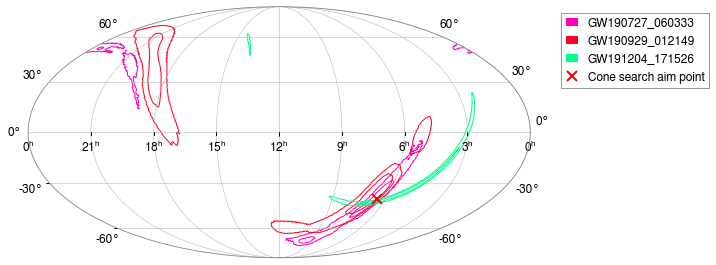

In [34]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=('astro hours mollweide'))
lpr = []
names = []
numevents = len(odatab)
ii = range(numevents)
maxevents = 15
ltitle=''
if numevents > maxevents:
    ii = np.random.randint(0, numevents, maxevents)
    numevents = maxevents
    ltitle = 'Too much events!\nShowing random subset'
a = np.linspace(0, 1, numevents)
np.random.shuffle(a)
colors = [rgb2hex(x) for x in plt.cm.gist_rainbow(a)]

for i in range(len(ii)):
    event = odatab[ii[i]]['commonName']
    if event == 'GW170817':
        pr, = ax.plot(197.45035417, -23.38148417,
                '+',
                transform=ax.get_transform('world'),
                markersize=10,
                markeredgewidth=2, 
                color=colors[i])    
        lpr.append(pr)
        names.append('GW170817')
    else:
        levels = good_levels.get(event, None)
        if levels is None:
            fits_file = f"./skymaps/{event}.fits"
            contour_levels = [50,90]
            skymap, metadata = read_sky_map(fits_file, nest=True)
            levels = 100 * find_greedy_credible_levels(skymap)
        cs = ax.contour_hpx(
                    (levels, 'ICRS'), nested=True,
                     colors=colors[i], linewidths=1, levels=contour_levels)
        lpr.append(plt.Rectangle((0,0),1,1,fc = colors[i]))
        names.append(event)
    i+=1

if do_cone_search:
    pr, = ax.plot(ra, dec,
            'rx',
            transform=ax.get_transform('world'),
            markersize=10,
            markeredgewidth=2,
            )   
    lpr.append(pr)
    names.append('Cone search aim point')

ax.grid(True)
ax.legend(lpr, names, numpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left', title=ltitle)

bio = BytesIO()
plt.savefig(bio, format='svg', bbox_inches="tight")
bio.seek(0)
image = base64.b64encode(bio.read())
bio.close()

In [9]:
asciicat = asciicat
skymap_files = skymap_files
image = image.decode()